# 02 - Exploratory Data Analysis

This notebook provides comprehensive exploratory analysis of the earthquake dataset including:
1. Descriptive Statistics
2. Magnitude Distribution
3. Depth Distribution
4. Spatial Distribution
5. Temporal Patterns
6. Correlation Analysis

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from visualization import setup_style, create_turkey_basemap

setup_style()

# Create output directory
OUTPUT_DIR = os.path.join(FIGURES_PATH, '02_eda')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TABLES_PATH, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/02_eda


In [2]:
# Load processed data
processed_file = os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv')

if not os.path.exists(processed_file):
    raise FileNotFoundError(
        f"Processed data not found at {processed_file}\n"
        "Please run notebook 01_data_loading_preprocessing.ipynb first!"
    )

eq_df = pd.read_csv(processed_file)
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

print(f"Loaded {len(eq_df):,} records")
print(f"Earthquakes (M >= 4.0): {(eq_df['category'] == 'Earthquake').sum():,}")
print(f"Tremors (M < 4.0): {(eq_df['category'] == 'Tremor').sum():,}")

Loaded 524,952 records
Earthquakes (M >= 4.0): 4,103
Tremors (M < 4.0): 520,849


## 2. Descriptive Statistics

In [3]:
# Overall statistics
print("=" * 60)
print("OVERALL STATISTICS")
print("=" * 60)
print(eq_df[['magnitude', 'depth', 'latitude', 'longitude']].describe().round(2))

OVERALL STATISTICS
       magnitude      depth   latitude  longitude
count  524952.00  524952.00  524952.00  524952.00
mean        1.98       8.17      38.52      32.92
std         0.71       5.41       1.25       5.52
min         0.20       0.00      35.50      25.50
25%         1.40       6.99      37.63      27.98
50%         1.90       7.00      38.46      30.81
75%         2.50       7.13      39.27      37.81
max         7.70     191.30      42.50      45.00


In [4]:
# Statistics by category
print("\n" + "=" * 60)
print("STATISTICS BY CATEGORY")
print("=" * 60)

for cat in ['Earthquake', 'Tremor']:
    subset = eq_df[eq_df['category'] == cat]
    print(f"\n{cat} (n = {len(subset):,}):")
    print(f"  Magnitude: {subset['magnitude'].mean():.2f} ± {subset['magnitude'].std():.2f} (range: {subset['magnitude'].min():.1f} - {subset['magnitude'].max():.1f})")
    print(f"  Depth: {subset['depth'].mean():.1f} ± {subset['depth'].std():.1f} km")


STATISTICS BY CATEGORY

Earthquake (n = 4,103):
  Magnitude: 4.34 ± 0.40 (range: 4.0 - 7.7)
  Depth: 12.9 ± 11.3 km

Tremor (n = 520,849):
  Magnitude: 1.96 ± 0.68 (range: 0.2 - 3.9)
  Depth: 8.1 ± 5.3 km


In [5]:
# Top provinces by earthquake count
print("\nTop 15 Provinces by Event Count:")
province_counts = eq_df.groupby('province').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max']
}).round(2)
province_counts.columns = ['count', 'mag_mean', 'mag_max']
province_counts = province_counts.sort_values('count', ascending=False)
print(province_counts.head(15))


Top 15 Provinces by Event Count:
               count  mag_mean  mag_max
province                               
Muğla          62335      2.00      6.5
İzmir          37572      2.05      6.6
Malatya        37361      1.74      5.9
Kahramanmaraş  32720      1.94      7.7
Balıkesir      31996      1.77      6.1
Manisa         24986      1.88      5.5
Kütahya        24732      2.03      5.4
Van            21480      2.40      6.7
Çanakkale      19196      1.99      5.6
Denizli        17361      1.96      6.0
Elazığ         13125      1.94      6.8
Adıyaman       11766      1.76      5.5
Ankara         11680      2.05      5.6
Adana          11136      1.95      5.9
Aydın          10569      2.04      5.1


## 3. Magnitude Distribution

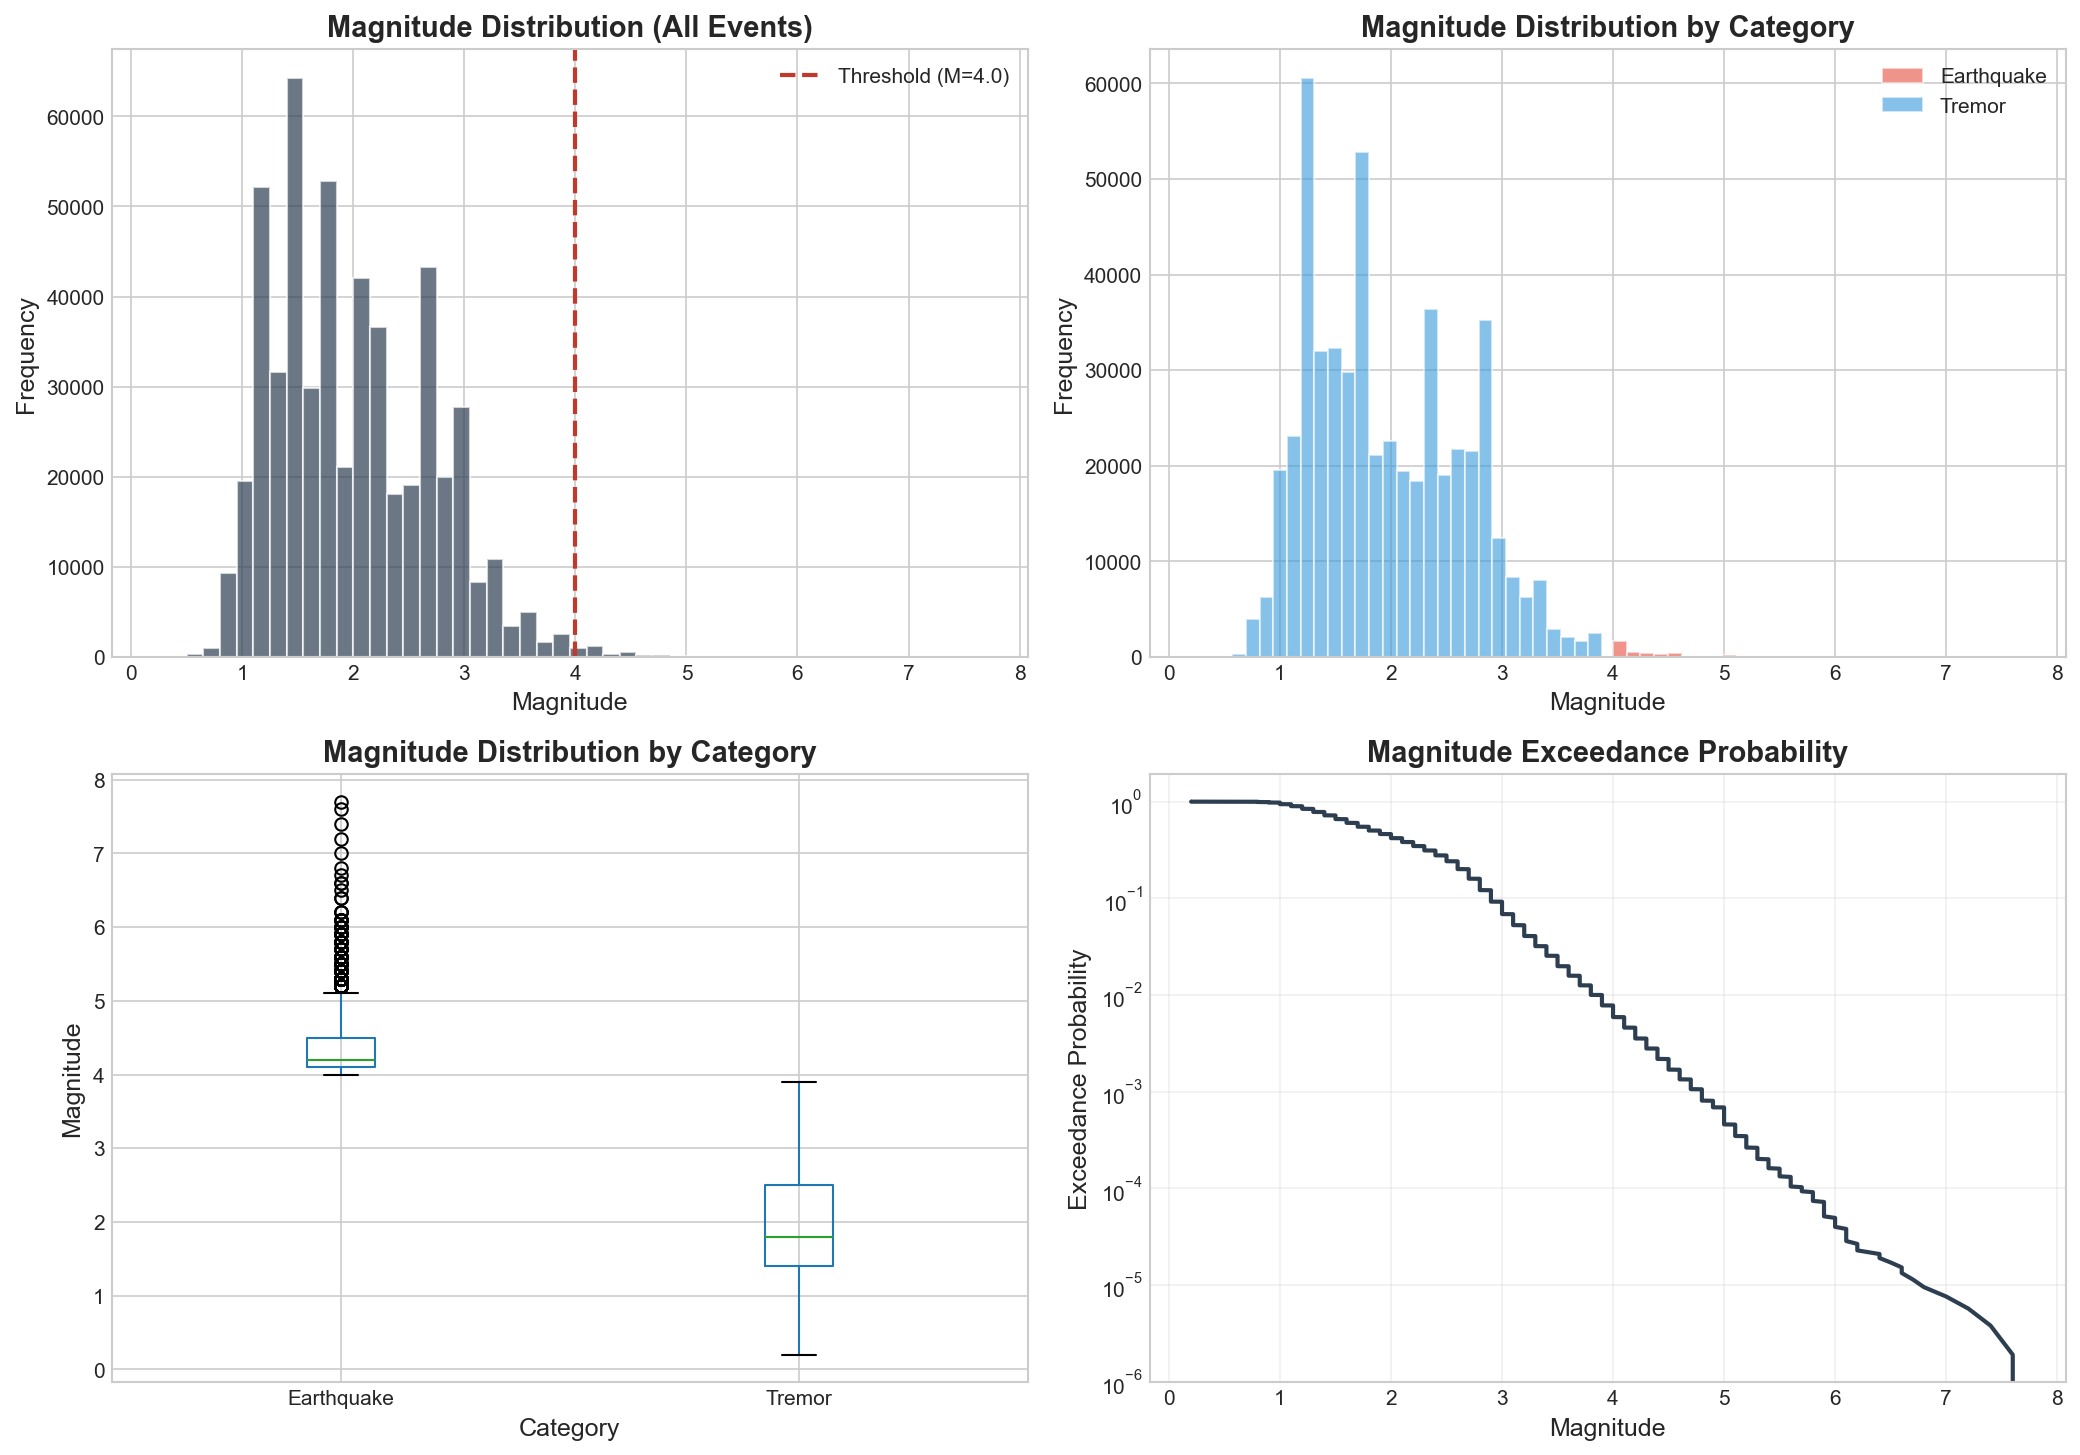

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram - All events
ax1 = axes[0, 0]
ax1.hist(eq_df['magnitude'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.axvline(MAGNITUDE_THRESHOLD, color=COLORS['danger'], linestyle='--', linewidth=2, 
            label=f'Threshold (M={MAGNITUDE_THRESHOLD})')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Frequency')
ax1.set_title('Magnitude Distribution (All Events)', fontweight='bold')
ax1.legend()

# Histogram - By category
ax2 = axes[0, 1]
for cat, color in [('Earthquake', COLORS['earthquake']), ('Tremor', COLORS['tremor'])]:
    subset = eq_df[eq_df['category'] == cat]
    ax2.hist(subset['magnitude'], bins=30, alpha=0.6, label=cat, color=color, edgecolor='white')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Frequency')
ax2.set_title('Magnitude Distribution by Category', fontweight='bold')
ax2.legend()

# Box plot by category
ax3 = axes[1, 0]
eq_df.boxplot(column='magnitude', by='category', ax=ax3)
ax3.set_xlabel('Category')
ax3.set_ylabel('Magnitude')
ax3.set_title('Magnitude Distribution by Category', fontweight='bold')
plt.suptitle('')  # Remove automatic title

# Cumulative distribution
ax4 = axes[1, 1]
sorted_mags = np.sort(eq_df['magnitude'])
cum_prob = np.arange(1, len(sorted_mags) + 1) / len(sorted_mags)
ax4.plot(sorted_mags, 1 - cum_prob, color=COLORS['primary'], linewidth=2)
ax4.set_yscale('log')
ax4.set_xlabel('Magnitude')
ax4.set_ylabel('Exceedance Probability')
ax4.set_title('Magnitude Exceedance Probability', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'magnitude_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Depth Distribution

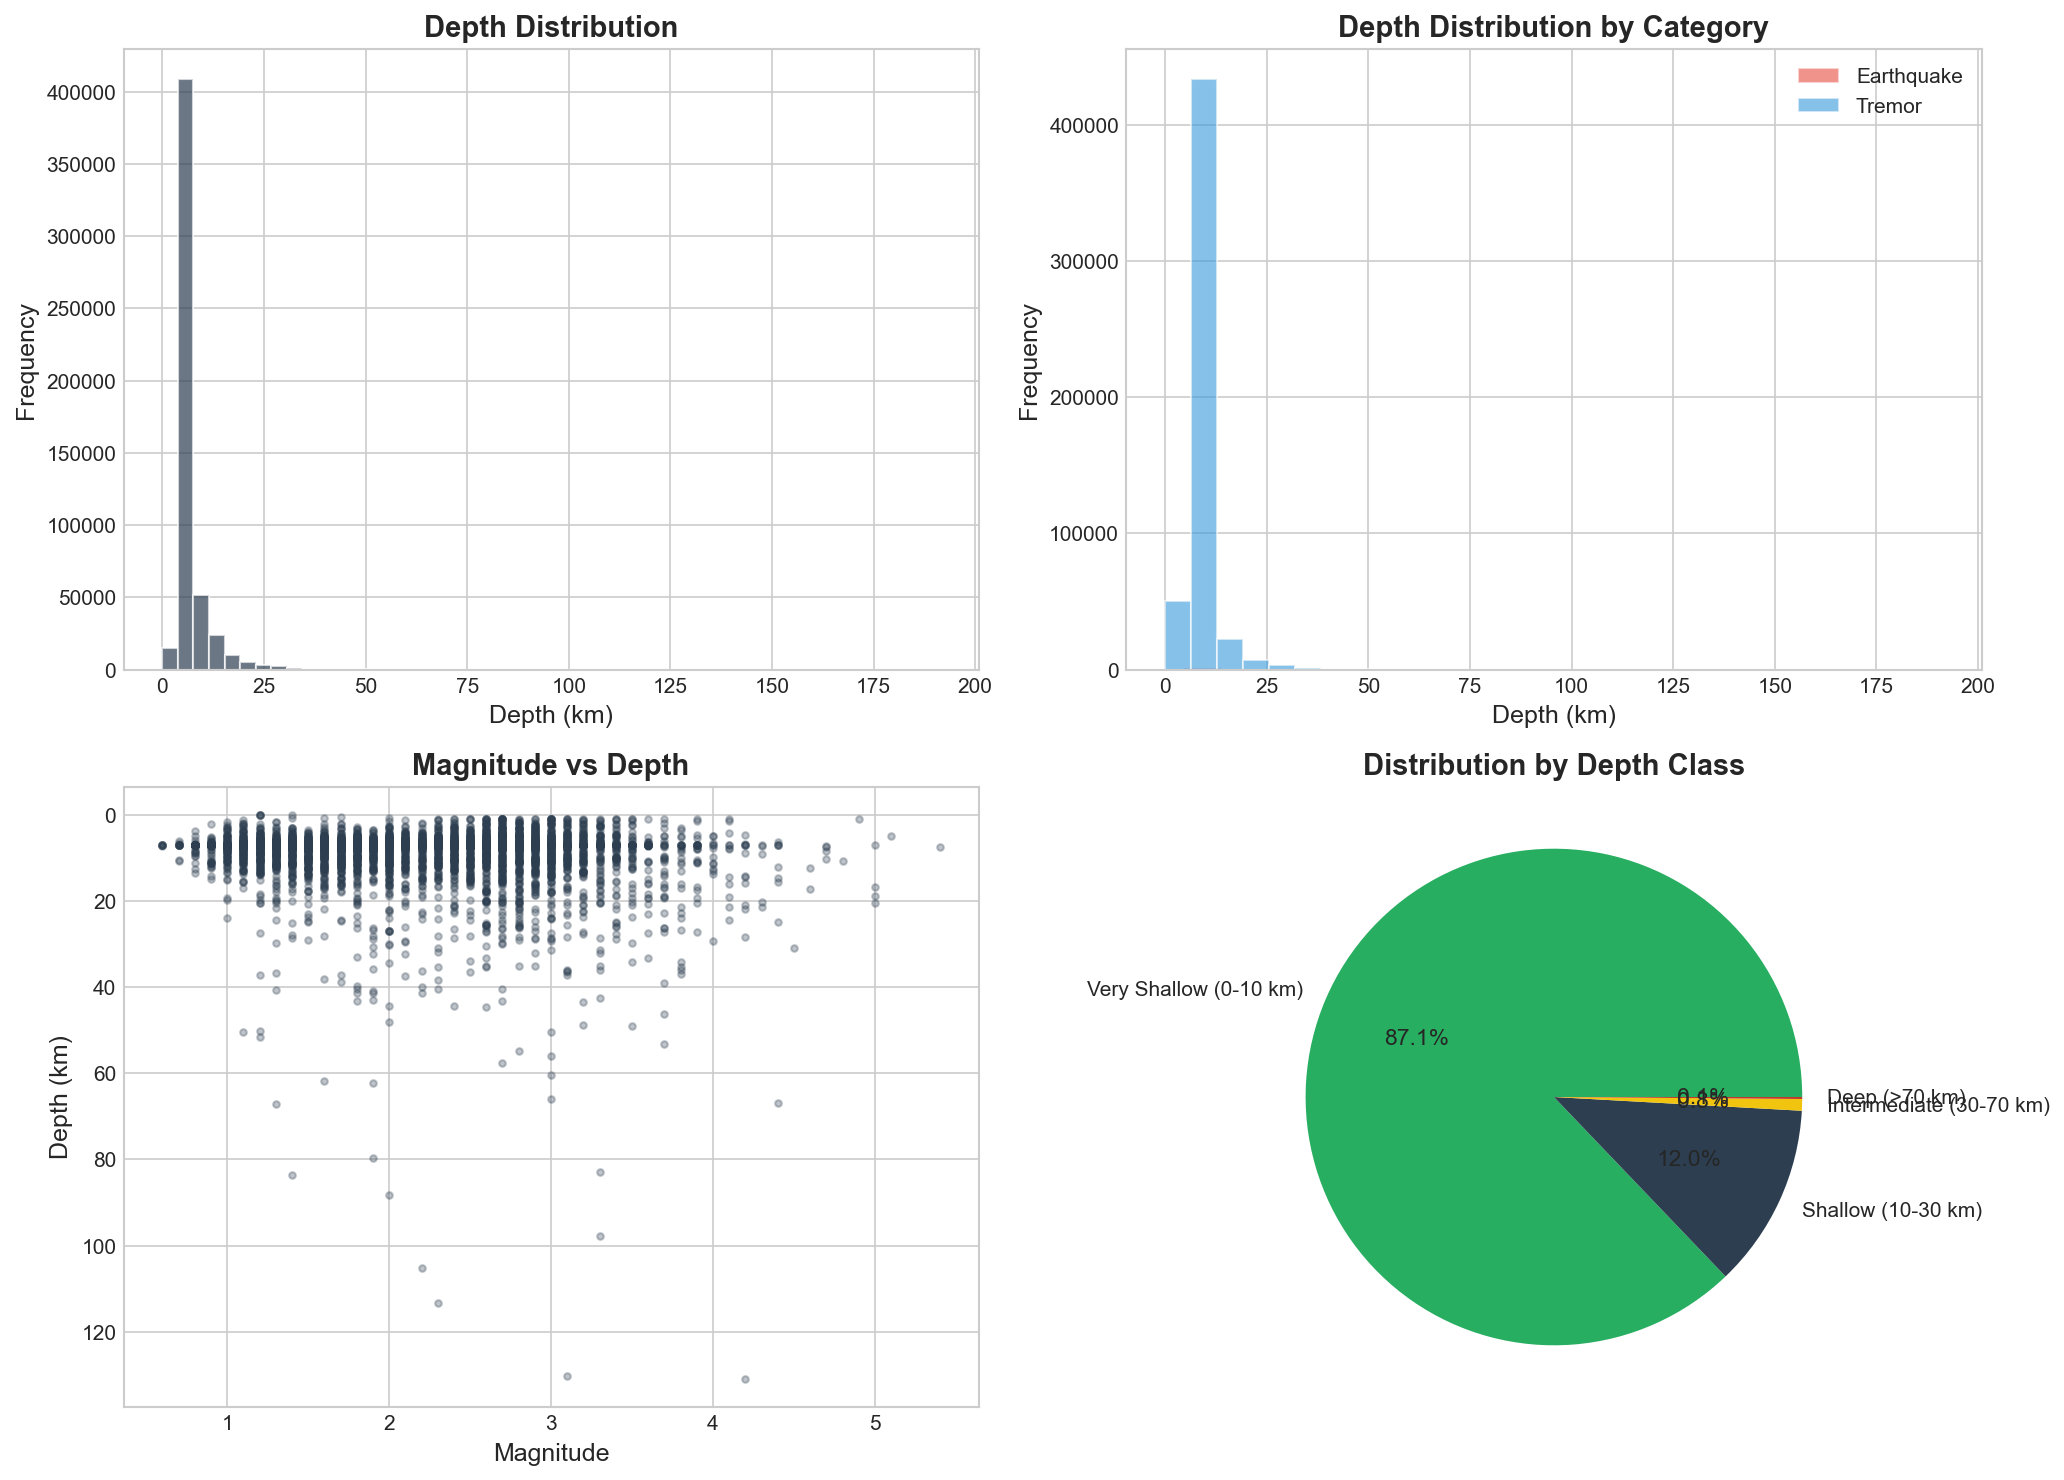

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
ax1 = axes[0, 0]
ax1.hist(eq_df['depth'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.set_xlabel('Depth (km)')
ax1.set_ylabel('Frequency')
ax1.set_title('Depth Distribution', fontweight='bold')

# Depth by category
ax2 = axes[0, 1]
for cat, color in [('Earthquake', COLORS['earthquake']), ('Tremor', COLORS['tremor'])]:
    subset = eq_df[eq_df['category'] == cat]
    ax2.hist(subset['depth'], bins=30, alpha=0.6, label=cat, color=color, edgecolor='white')
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Frequency')
ax2.set_title('Depth Distribution by Category', fontweight='bold')
ax2.legend()

# Depth vs Magnitude scatter
ax3 = axes[1, 0]
sample = eq_df.sample(min(10000, len(eq_df)), random_state=42)
ax3.scatter(sample['magnitude'], sample['depth'], alpha=0.3, s=10, c=COLORS['primary'])
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('Depth (km)')
ax3.set_title('Magnitude vs Depth', fontweight='bold')
ax3.invert_yaxis()

# Depth class distribution
ax4 = axes[1, 1]
depth_counts = eq_df['depth_class'].value_counts()
colors = [COLORS['success'], COLORS['primary'], COLORS['warning'], COLORS['danger']]
ax4.pie(depth_counts, labels=depth_counts.index, autopct='%1.1f%%', colors=colors[:len(depth_counts)])
ax4.set_title('Distribution by Depth Class', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'depth_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Spatial Distribution

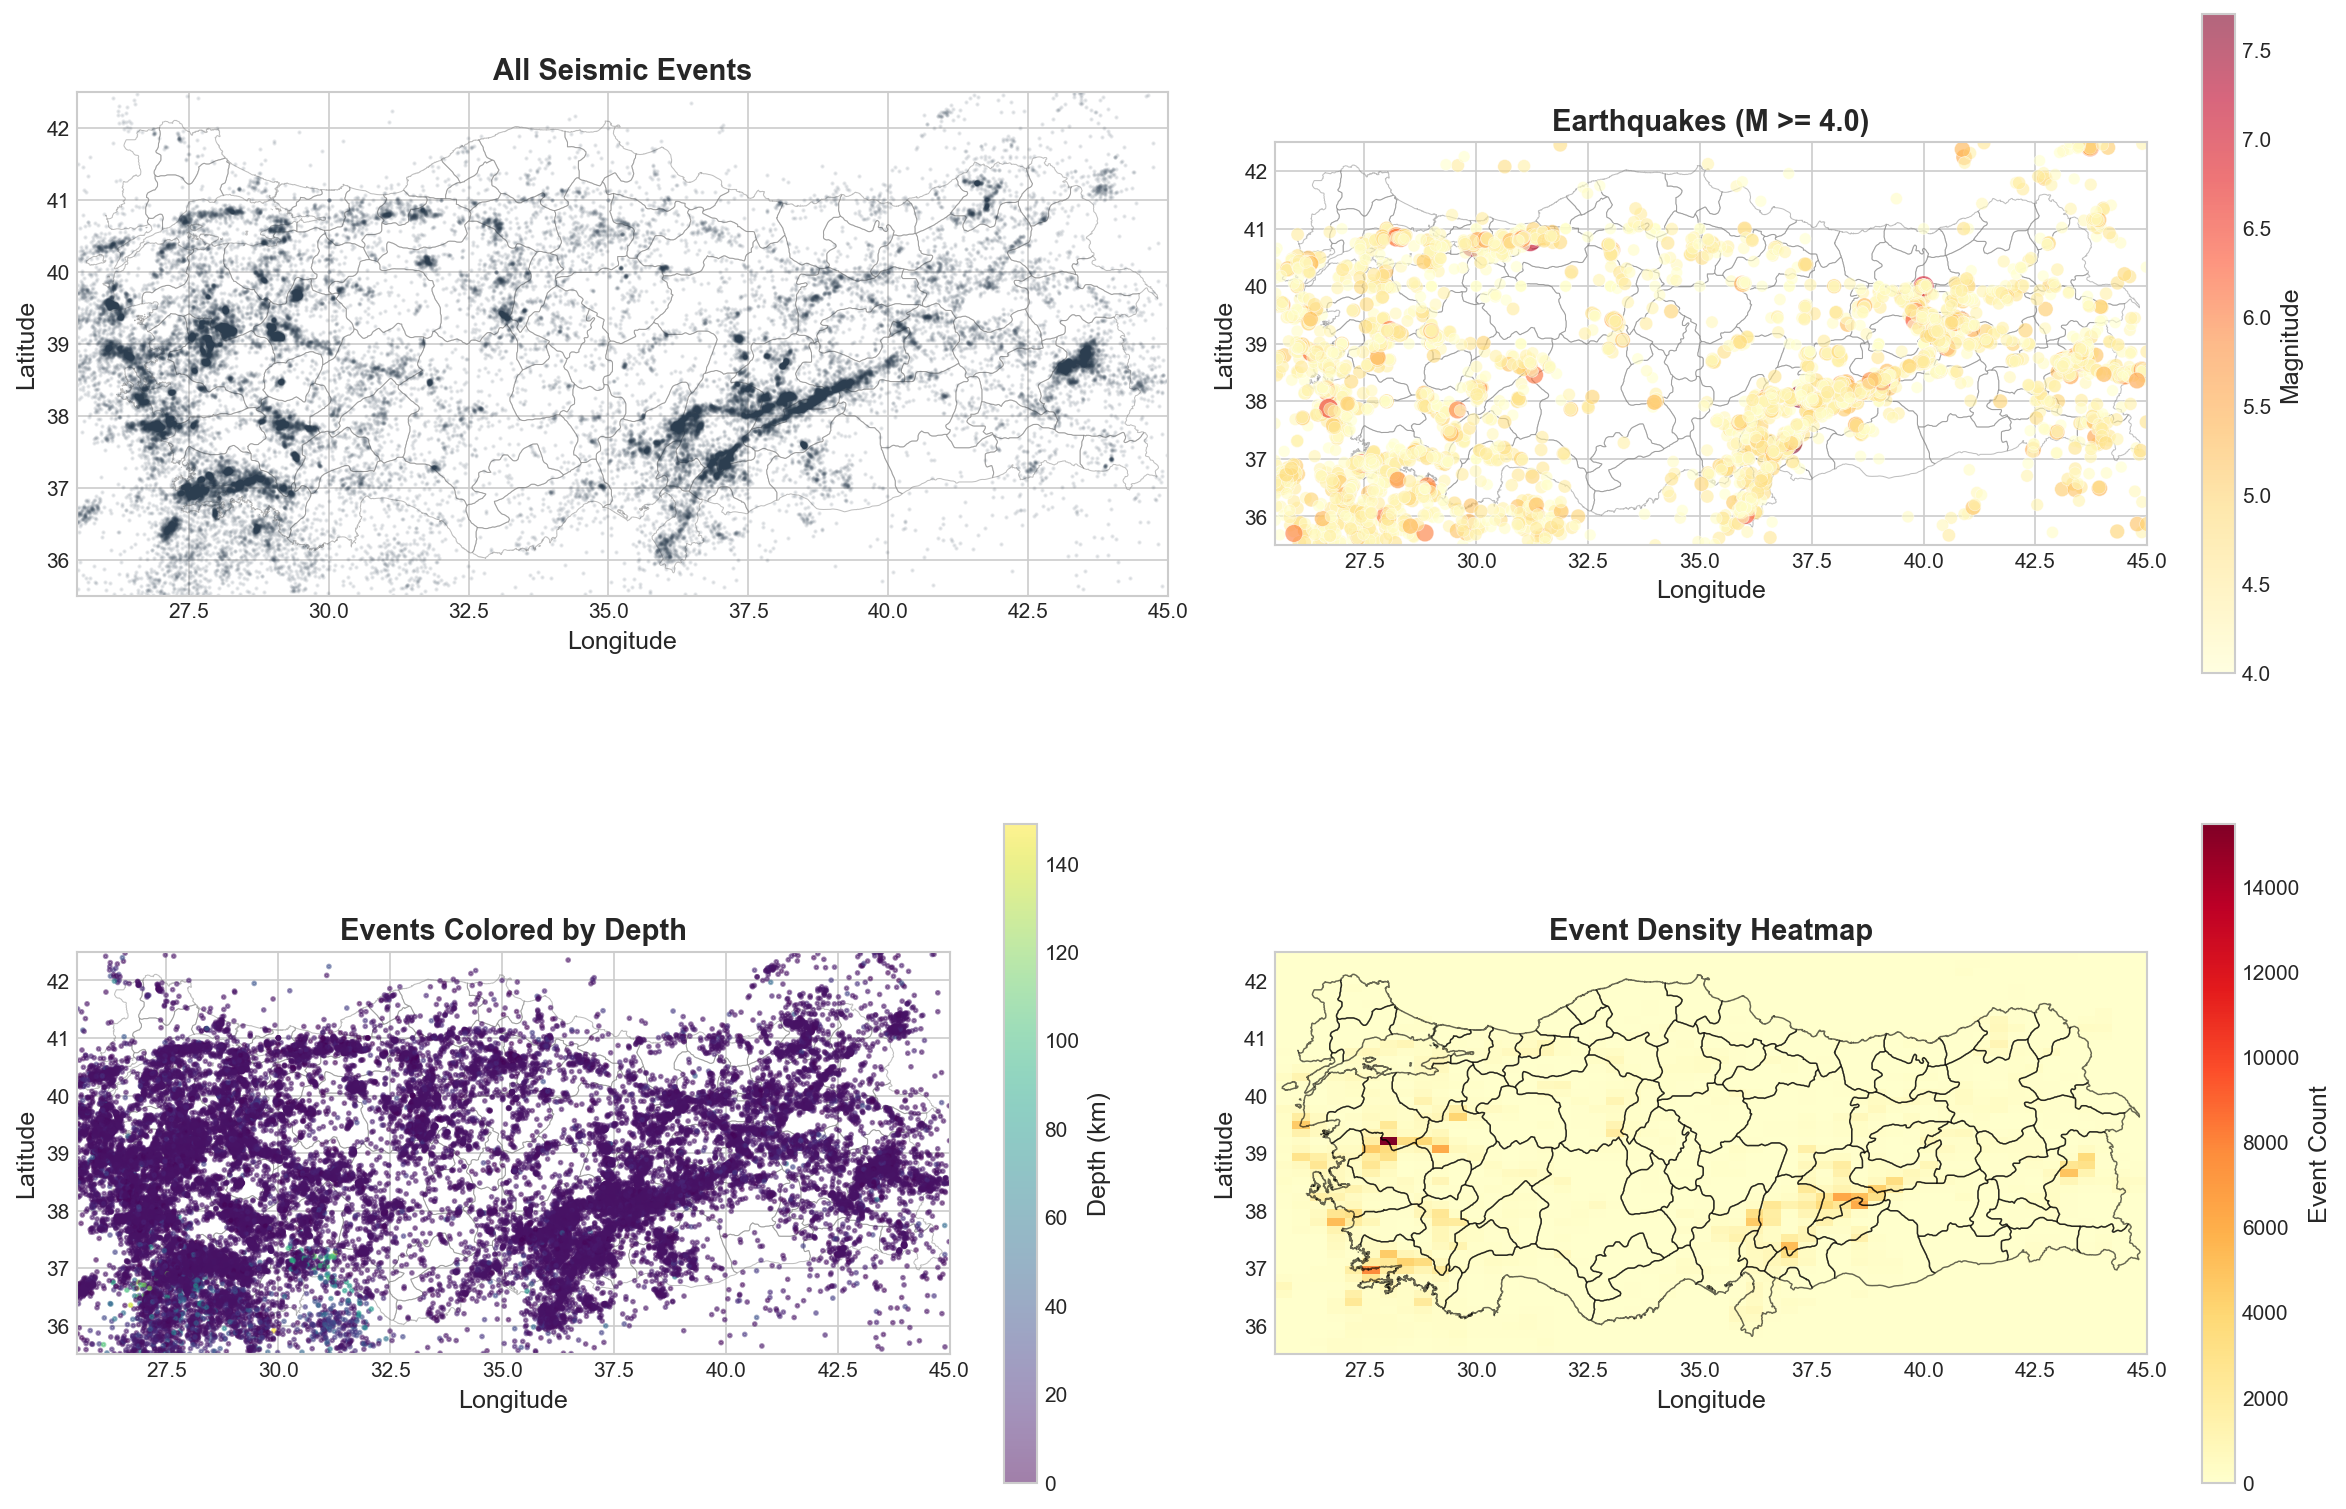

In [8]:
# Import Turkey map functions
import sys
sys.path.insert(0, '../src')
from visualization import load_turkey_provinces

# Load Turkey province boundaries
turkey_gdf = load_turkey_provinces()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# All events
ax1 = create_turkey_basemap(axes[0, 0], 'All Seismic Events')
turkey_gdf.boundary.plot(ax=ax1, linewidth=0.5, color='gray', alpha=0.5, zorder=1)
sample = eq_df.sample(min(50000, len(eq_df)), random_state=42)
ax1.scatter(sample['longitude'], sample['latitude'], s=1, alpha=0.1, c=COLORS['primary'], zorder=2)

# Earthquakes only (M >= 4.0)
ax2 = create_turkey_basemap(axes[0, 1], 'Earthquakes (M >= 4.0)')
turkey_gdf.boundary.plot(ax=ax2, linewidth=0.5, color='gray', alpha=0.5, zorder=1)
earthquakes = eq_df[eq_df['category'] == 'Earthquake']
scatter = ax2.scatter(earthquakes['longitude'], earthquakes['latitude'], 
                      c=earthquakes['magnitude'], s=earthquakes['magnitude']**2 * 2,
                      cmap='YlOrRd', alpha=0.6, edgecolors='white', linewidth=0.3, zorder=2)
plt.colorbar(scatter, ax=ax2, label='Magnitude', shrink=0.7)

# Colored by depth
ax3 = create_turkey_basemap(axes[1, 0], 'Events Colored by Depth')
turkey_gdf.boundary.plot(ax=ax3, linewidth=0.5, color='gray', alpha=0.5, zorder=1)
scatter2 = ax3.scatter(sample['longitude'], sample['latitude'], 
                       c=sample['depth'], s=3, cmap=DEPTH_CMAP, alpha=0.5, zorder=2)
plt.colorbar(scatter2, ax=ax3, label='Depth (km)', shrink=0.7)

# 2D histogram / heatmap
ax4 = create_turkey_basemap(axes[1, 1], 'Event Density Heatmap')
h = ax4.hist2d(eq_df['longitude'], eq_df['latitude'], bins=50, cmap=DENSITY_CMAP, 
               range=[[TURKEY_BOUNDS['lon_min'], TURKEY_BOUNDS['lon_max']], 
                      [TURKEY_BOUNDS['lat_min'], TURKEY_BOUNDS['lat_max']]], zorder=1)
turkey_gdf.boundary.plot(ax=ax4, linewidth=0.7, color='black', alpha=0.6, zorder=2)
plt.colorbar(h[3], ax=ax4, label='Event Count', shrink=0.7)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'spatial_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Temporal Patterns

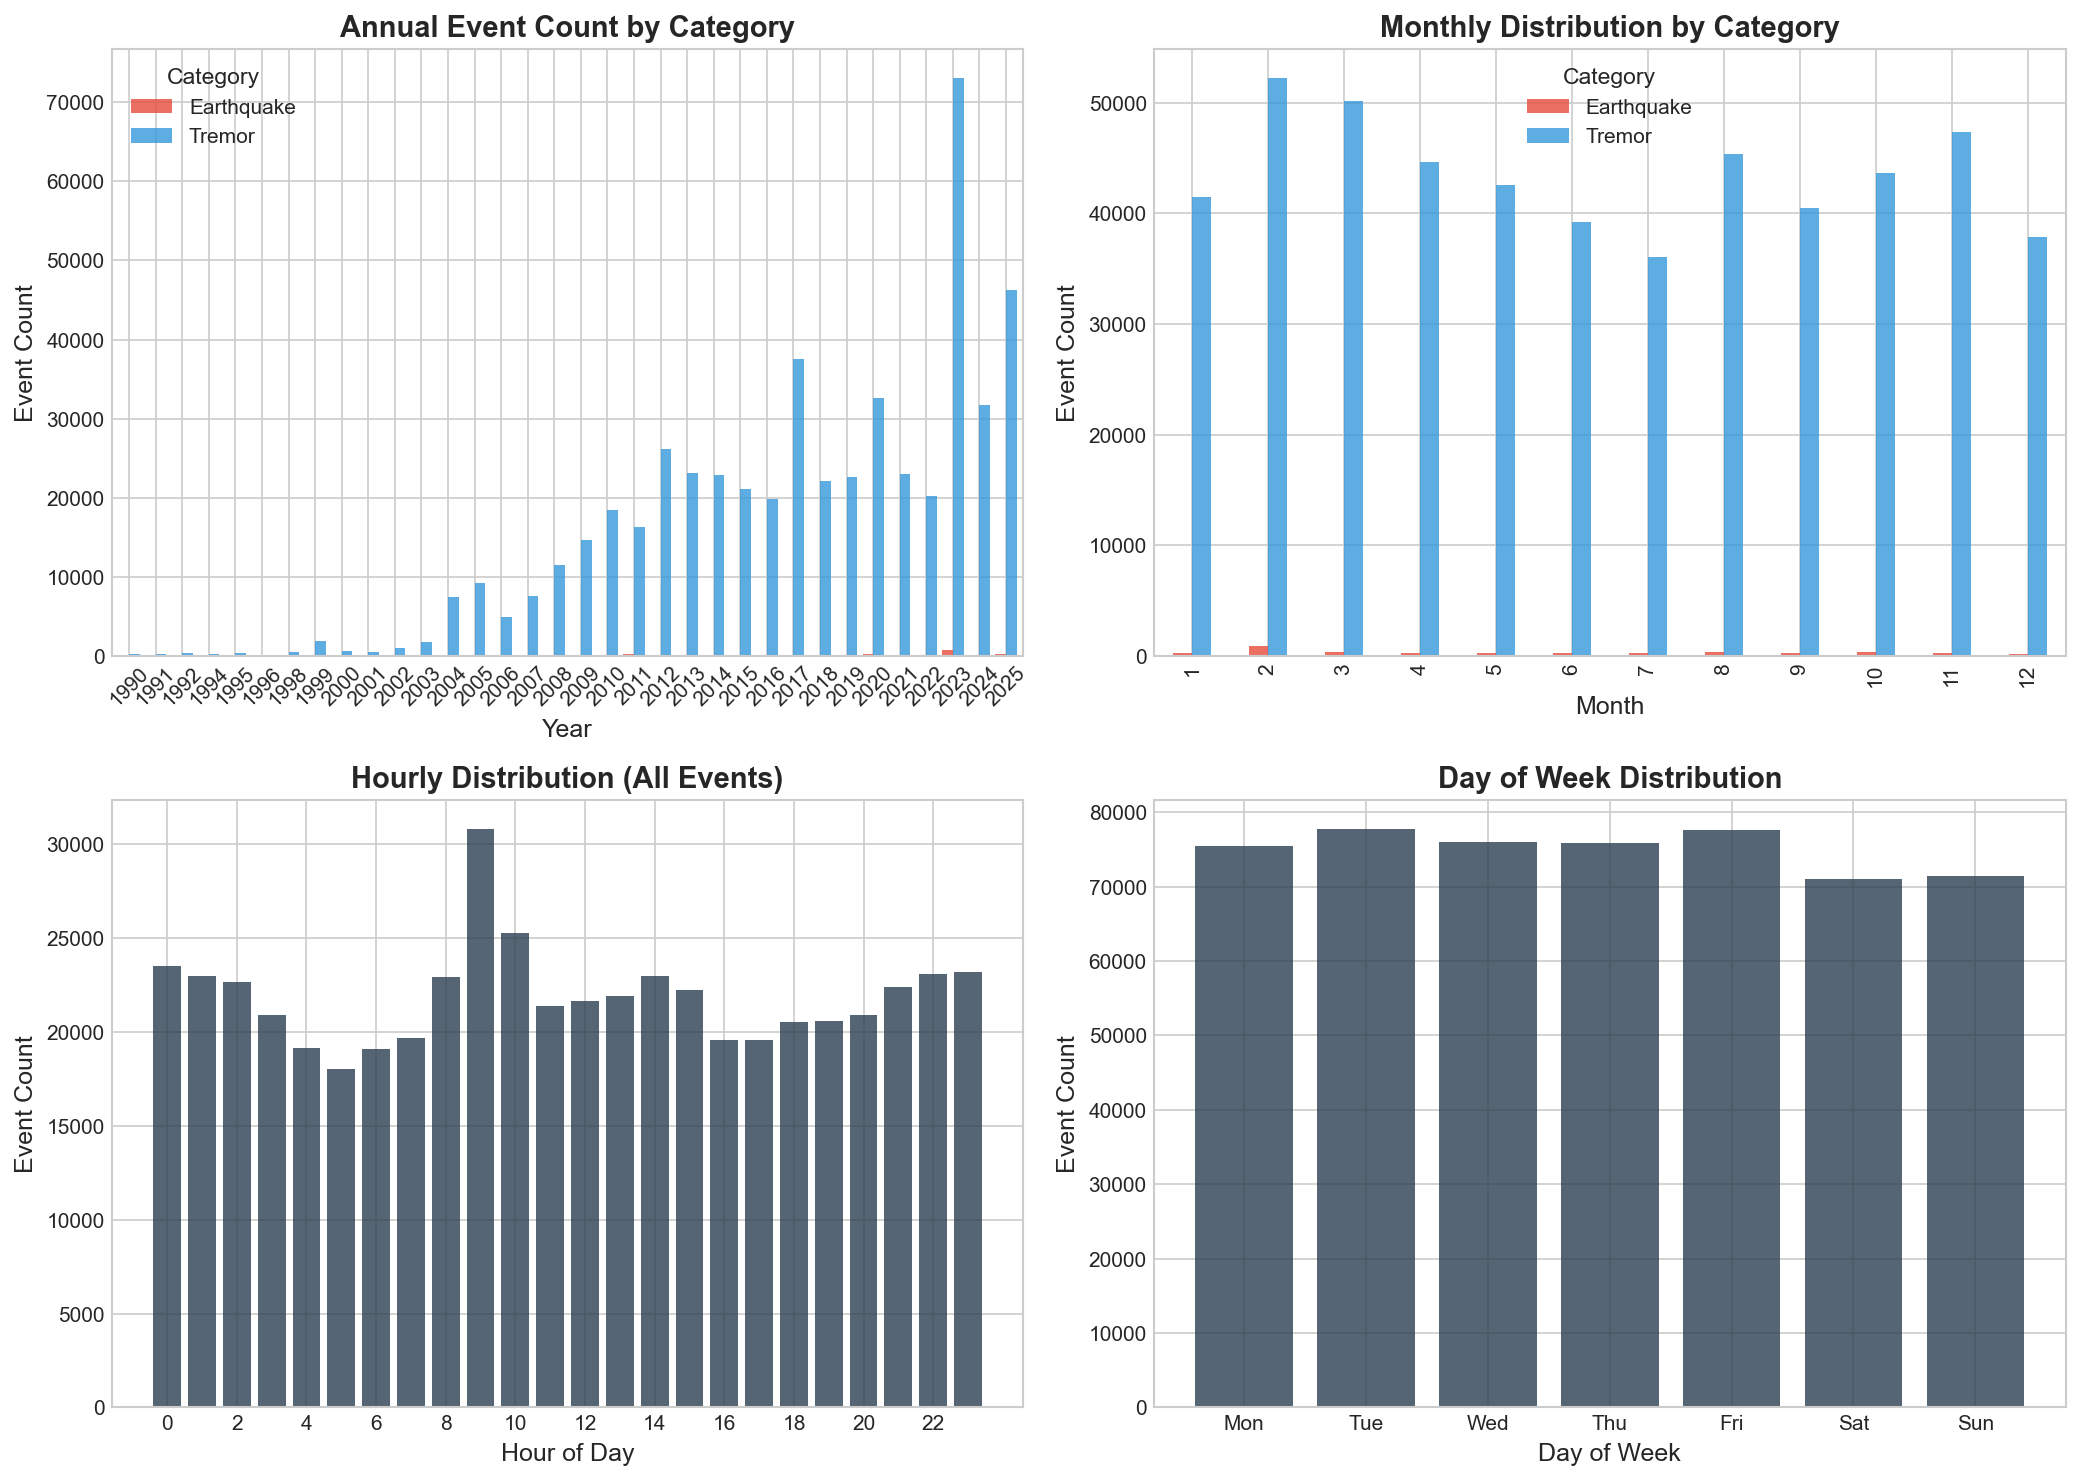

In [9]:
# Yearly trend
yearly = eq_df.groupby(['year', 'category']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Yearly counts
ax1 = axes[0, 0]
yearly.plot(kind='bar', ax=ax1, color=[COLORS['earthquake'], COLORS['tremor']], alpha=0.8, width=0.8)
ax1.set_xlabel('Year')
ax1.set_ylabel('Event Count')
ax1.set_title('Annual Event Count by Category', fontweight='bold')
ax1.legend(title='Category')
ax1.tick_params(axis='x', rotation=45)

# Monthly pattern
ax2 = axes[0, 1]
monthly = eq_df.groupby(['month', 'category']).size().unstack(fill_value=0)
monthly.plot(kind='bar', ax=ax2, color=[COLORS['earthquake'], COLORS['tremor']], alpha=0.8)
ax2.set_xlabel('Month')
ax2.set_ylabel('Event Count')
ax2.set_title('Monthly Distribution by Category', fontweight='bold')
ax2.legend(title='Category')

# Hourly pattern
ax3 = axes[1, 0]
hourly = eq_df.groupby('hour').size()
ax3.bar(hourly.index, hourly.values, color=COLORS['primary'], alpha=0.8)
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Event Count')
ax3.set_title('Hourly Distribution (All Events)', fontweight='bold')
ax3.set_xticks(range(0, 24, 2))

# Day of week pattern
ax4 = axes[1, 1]
dow = eq_df.groupby('day_of_week').size()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax4.bar(range(7), dow.values, color=COLORS['primary'], alpha=0.8)
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Event Count')
ax4.set_title('Day of Week Distribution', fontweight='bold')
ax4.set_xticks(range(7))
ax4.set_xticklabels(days)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

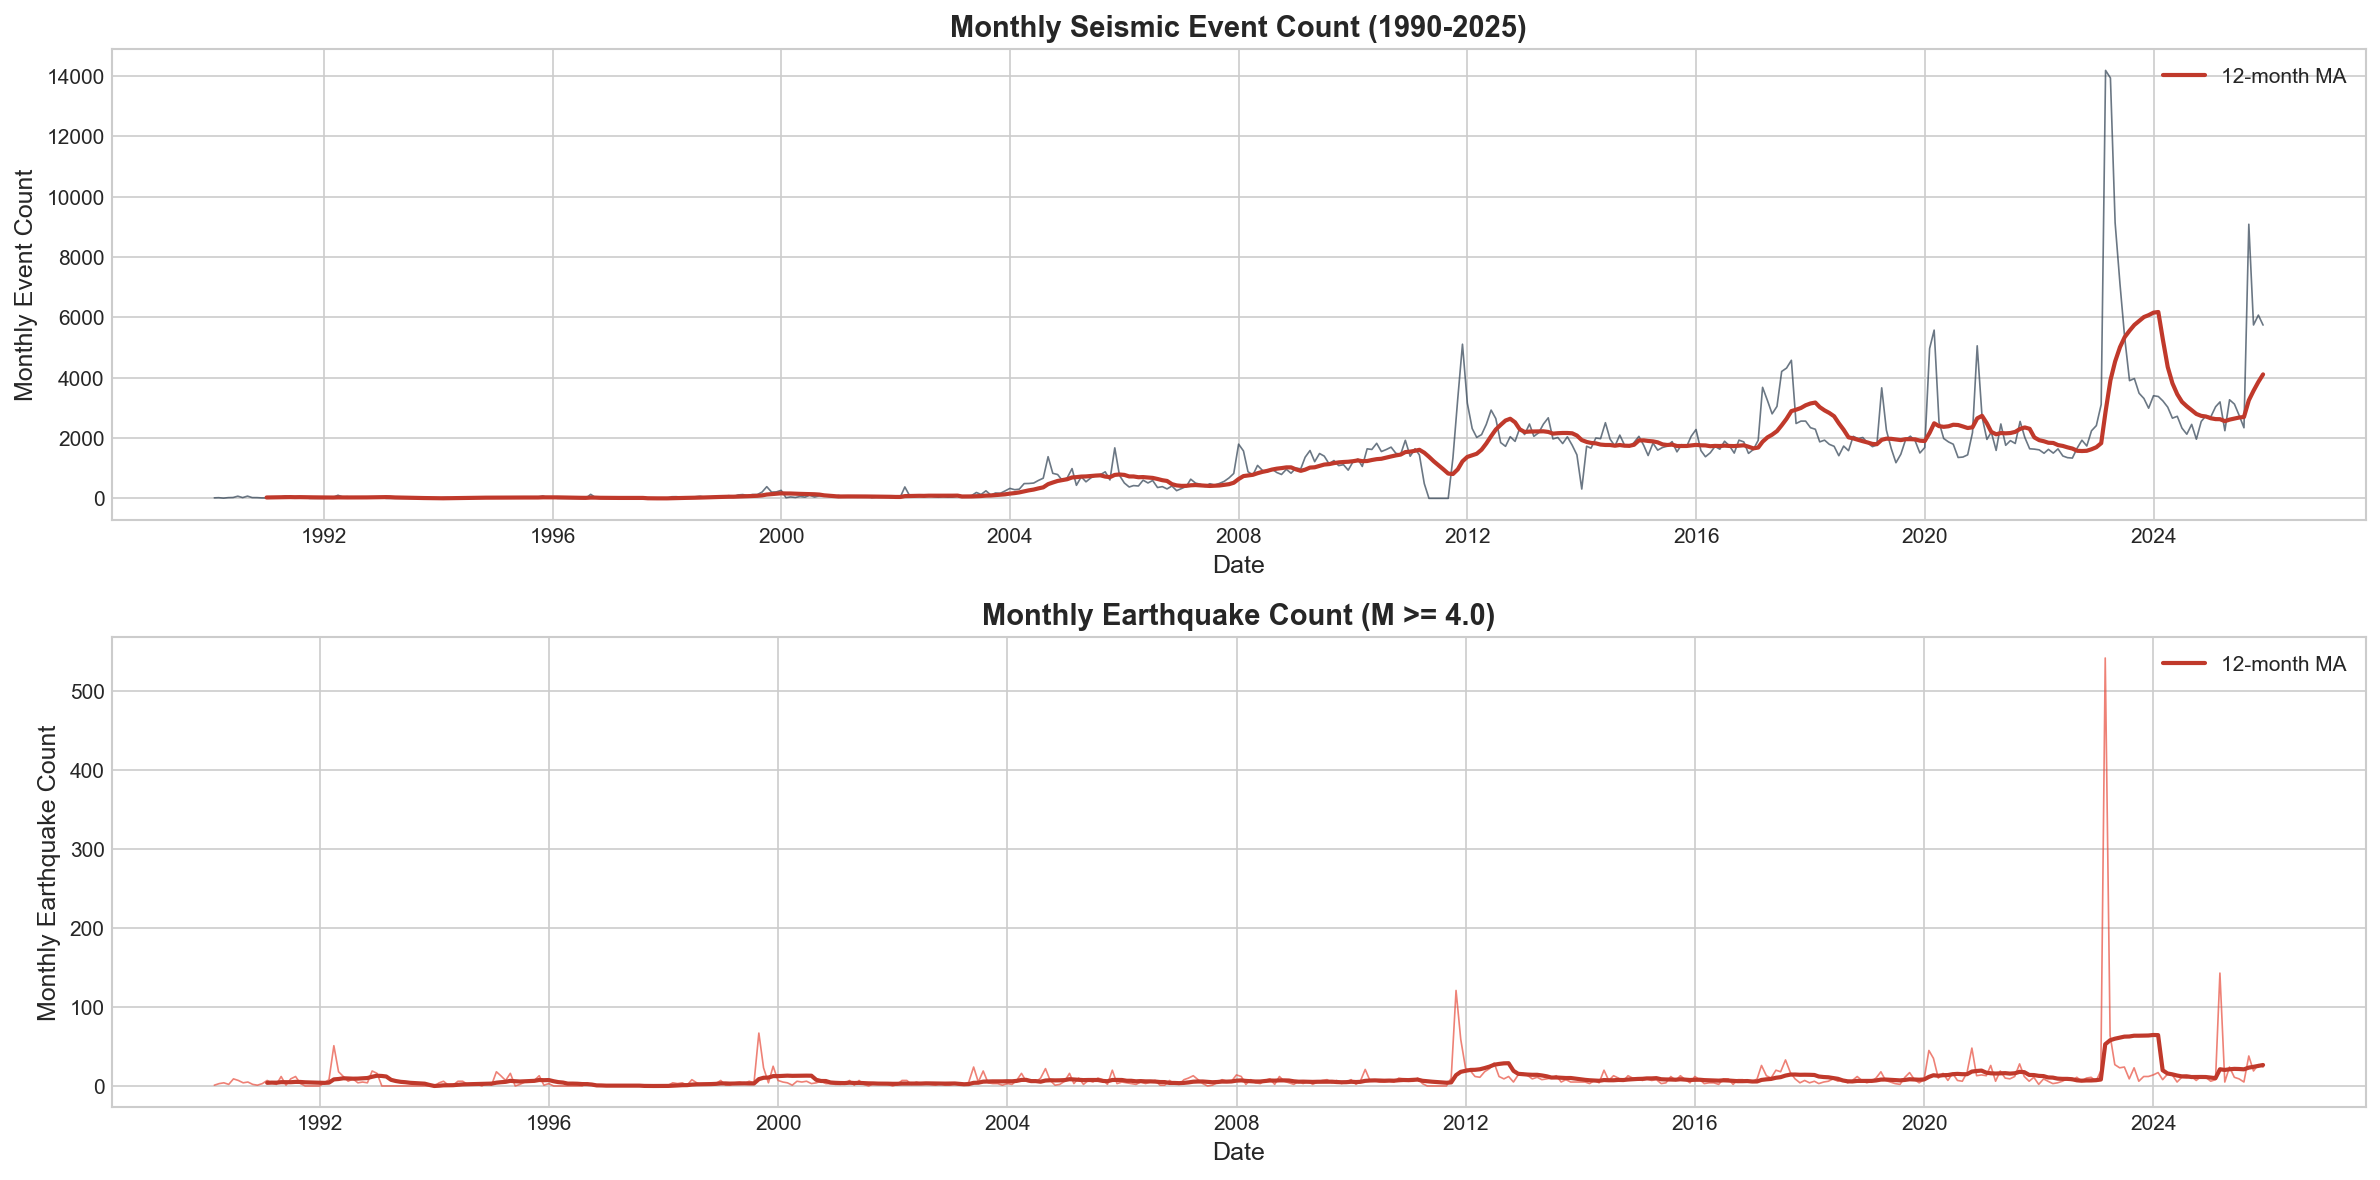

In [10]:
# Time series of earthquake counts
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Monthly time series
monthly_ts = eq_df.set_index('date').resample('M').size()

ax1 = axes[0]
ax1.plot(monthly_ts.index, monthly_ts.values, color=COLORS['primary'], linewidth=0.8, alpha=0.7)
# Add rolling average
rolling = monthly_ts.rolling(window=12).mean()
ax1.plot(rolling.index, rolling.values, color=COLORS['danger'], linewidth=2, label='12-month MA')
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Event Count')
ax1.set_title('Monthly Seismic Event Count (1990-2025)', fontweight='bold')
ax1.legend()

# Earthquakes only (M >= 4.0)
eq_only = eq_df[eq_df['category'] == 'Earthquake'].set_index('date').resample('M').size()

ax2 = axes[1]
ax2.plot(eq_only.index, eq_only.values, color=COLORS['earthquake'], linewidth=0.8, alpha=0.7)
rolling_eq = eq_only.rolling(window=12).mean()
ax2.plot(rolling_eq.index, rolling_eq.values, color=COLORS['danger'], linewidth=2, label='12-month MA')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Earthquake Count')
ax2.set_title('Monthly Earthquake Count (M >= 4.0)', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'time_series.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Correlation Analysis

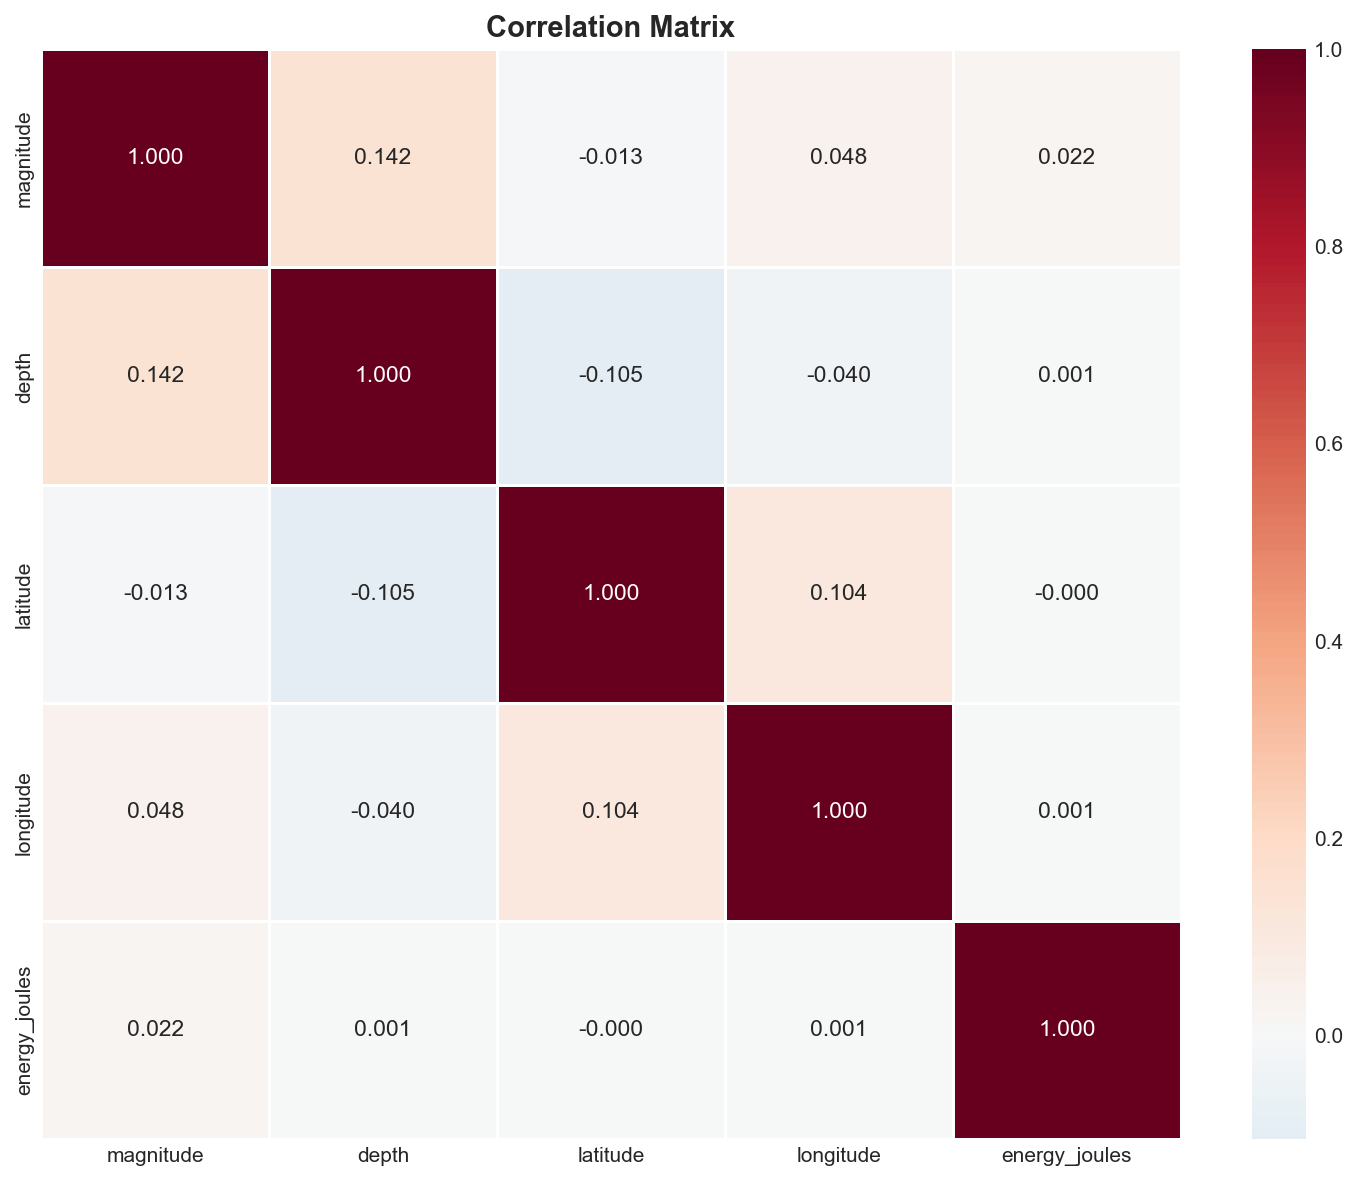


Correlation Statistics:
               magnitude     depth  latitude  longitude  energy_joules
magnitude       1.000000  0.141682 -0.012981   0.048052       0.021806
depth           0.141682  1.000000 -0.105160  -0.040397       0.001070
latitude       -0.012981 -0.105160  1.000000   0.103914      -0.000267
longitude       0.048052 -0.040397  0.103914   1.000000       0.001413
energy_joules   0.021806  0.001070 -0.000267   0.001413       1.000000


In [11]:
# Correlation matrix for numeric variables
numeric_cols = ['magnitude', 'depth', 'latitude', 'longitude', 'energy_joules']
corr_matrix = eq_df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation Statistics:")
print(corr_matrix)

In [12]:
# Statistical tests
print("=" * 60)
print("STATISTICAL TESTS")
print("=" * 60)

# Test: Is earthquake frequency uniform across months?
monthly_counts = eq_df['month'].value_counts().sort_index()
expected = np.full(12, len(eq_df) / 12)
chi2, p_value = stats.chisquare(monthly_counts.values, expected)
print(f"\nChi-square test for uniform monthly distribution:")
print(f"  Chi² = {chi2:.2f}, p-value = {p_value:.4e}")
print(f"  Result: {'NOT uniform' if p_value < 0.05 else 'Uniform'} (α=0.05)")

# Test: Magnitude vs Depth correlation
r, p = stats.pearsonr(eq_df['magnitude'], eq_df['depth'])
print(f"\nPearson correlation (Magnitude vs Depth):")
print(f"  r = {r:.4f}, p-value = {p:.4e}")

# Test: Difference in depth between earthquakes and tremors
eq_depth = eq_df[eq_df['category'] == 'Earthquake']['depth']
tr_depth = eq_df[eq_df['category'] == 'Tremor']['depth']
t_stat, p_value = stats.ttest_ind(eq_depth, tr_depth)
print(f"\nT-test for depth difference (Earthquake vs Tremor):")
print(f"  t = {t_stat:.2f}, p-value = {p_value:.4e}")
print(f"  Mean depth - Earthquake: {eq_depth.mean():.1f} km, Tremor: {tr_depth.mean():.1f} km")

STATISTICAL TESTS

Chi-square test for uniform monthly distribution:
  Chi² = 6250.57, p-value = 0.0000e+00
  Result: NOT uniform (α=0.05)

Pearson correlation (Magnitude vs Depth):
  r = 0.1417, p-value = 0.0000e+00

T-test for depth difference (Earthquake vs Tremor):
  t = 56.20, p-value = 0.0000e+00
  Mean depth - Earthquake: 12.9 km, Tremor: 8.1 km


## 8. Post-hoc Statistical Tests

Additional statistical analyses with post-hoc tests (Tukey HSD for ANOVA, Adjusted Standardized Residuals for Chi-square).

In [13]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("=" * 70)
print("POST-HOC ANALYSIS 1: Soil Class vs Magnitude (ANOVA + Tukey HSD)")
print("=" * 70)

# Filter to records with soil class data
eq_with_soil = eq_df[eq_df['soil_class'].notna()].copy()

# ANOVA: Test if mean magnitude differs across soil classes
groups_soil = [group['magnitude'].values for name, group in eq_with_soil.groupby('soil_class')]
f_stat, p_value = f_oneway(*groups_soil)
print(f"\nANOVA: F = {f_stat:.4f}, p-value = {p_value:.4e}")

if p_value < 0.05:
    print("\nSince p < 0.05, performing Tukey HSD post-hoc test:")
    tukey_soil = pairwise_tukeyhsd(eq_with_soil['magnitude'], eq_with_soil['soil_class'], alpha=0.05)
    print(tukey_soil)
    
    # Save results
    tukey_df = pd.DataFrame(data=tukey_soil._results_table.data[1:], 
                            columns=tukey_soil._results_table.data[0])
    tukey_df.to_csv(os.path.join(TABLES_PATH, 'soil_magnitude_tukey.csv'), index=False)
    print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'soil_magnitude_tukey.csv')}")
else:
    print("No significant difference found (p >= 0.05)")

POST-HOC ANALYSIS 1: Soil Class vs Magnitude (ANOVA + Tukey HSD)



ANOVA: F = 280.4048, p-value = 1.9408e-122

Since p < 0.05, performing Tukey HSD post-hoc test:


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower   upper  reject
--------------------------------------------------
    ZB     ZC  -0.0101   0.0 -0.015 -0.0052   True
    ZB     ZE   0.0745   0.0 0.0659  0.0832   True
    ZC     ZE   0.0846   0.0 0.0763   0.093   True
--------------------------------------------------

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/soil_magnitude_tukey.csv


In [14]:
print("\n" + "=" * 70)
print("POST-HOC ANALYSIS 2: Moon Phase vs Earthquake Frequency (Chi-square + ASR)")
print("=" * 70)

# Count earthquakes per moon phase (ALL earthquakes, not just M>=4)
phase_counts = eq_df['moon_phase'].value_counts()
n_phases = len(phase_counts)
expected = len(eq_df) / n_phases  # Uniform expectation

# Chi-square goodness-of-fit test
observed = phase_counts.values
chi2, p_value = stats.chisquare(observed)
print(f"\nChi-square Goodness-of-Fit Test:")
print(f"  Chi² = {chi2:.4f}, p-value = {p_value:.4e}")
print(f"  Expected count per phase (uniform): {expected:.0f}")
print(f"\n  Observed counts:")
for phase, count in phase_counts.items():
    print(f"    {phase}: {count:,}")

if p_value < 0.05:
    print("\nSince p < 0.05, calculating Adjusted Standardized Residuals (ASR):")
    print("  (ASR > +2 → more than expected, ASR < -2 → fewer than expected)\n")
    
    asr_results = []
    for phase, obs in phase_counts.items():
        # Standardized residual = (O - E) / sqrt(E)
        residual = (obs - expected) / np.sqrt(expected)
        sig = "***" if abs(residual) > 2 else ""
        interpretation = "MORE" if residual > 2 else ("FEWER" if residual < -2 else "expected")
        print(f"    {phase}: ASR = {residual:.2f} {sig} ({interpretation})")
        asr_results.append({'moon_phase': phase, 'observed': obs, 'expected': expected, 
                          'ASR': residual, 'significant': abs(residual) > 2})
    
    # Save results
    asr_df = pd.DataFrame(asr_results)
    asr_df.to_csv(os.path.join(TABLES_PATH, 'moon_phase_frequency_chi2.csv'), index=False)
    print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'moon_phase_frequency_chi2.csv')}")
else:
    print("No significant deviation from uniform distribution (p >= 0.05)")


POST-HOC ANALYSIS 2: Moon Phase vs Earthquake Frequency (Chi-square + ASR)

Chi-square Goodness-of-Fit Test:
  Chi² = 330302.8518, p-value = 0.0000e+00
  Expected count per phase (uniform): 131238

  Observed counts:
    Waning: 304,525
    New Moon: 120,240
    Waxing: 53,972
    Full Moon: 46,215

Since p < 0.05, calculating Adjusted Standardized Residuals (ASR):
  (ASR > +2 → more than expected, ASR < -2 → fewer than expected)

    Waning: ASR = 478.34 *** (MORE)
    New Moon: ASR = -30.36 *** (FEWER)
    Waxing: ASR = -213.28 *** (FEWER)
    Full Moon: ASR = -234.70 *** (FEWER)

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/moon_phase_frequency_chi2.csv


In [15]:
print("\n" + "=" * 70)
print("POST-HOC ANALYSIS 3: Moon Illumination vs Earthquake Frequency (Chi-square + ASR)")
print("=" * 70)

# Bin illumination into categories
eq_df['illum_bin'] = pd.cut(eq_df['illumination'], bins=[0, 25, 50, 75, 100],
                            labels=['0-25%', '25-50%', '50-75%', '75-100%'])
illum_counts = eq_df['illum_bin'].value_counts().sort_index()
n_bins = len(illum_counts)
expected_illum = len(eq_df.dropna(subset=['illum_bin'])) / n_bins

# Chi-square goodness-of-fit test
observed_illum = illum_counts.values
chi2_illum, p_value_illum = stats.chisquare(observed_illum)
print(f"\nChi-square Goodness-of-Fit Test:")
print(f"  Chi² = {chi2_illum:.4f}, p-value = {p_value_illum:.4e}")
print(f"  Expected count per bin (uniform): {expected_illum:.0f}")
print(f"\n  Observed counts:")
for illum_bin, count in illum_counts.items():
    print(f"    {illum_bin}: {count:,}")

if p_value_illum < 0.05:
    print("\nSince p < 0.05, calculating Adjusted Standardized Residuals (ASR):")
    print("  (ASR > +2 → more than expected, ASR < -2 → fewer than expected)\n")
    
    asr_illum_results = []
    for illum_bin, obs in illum_counts.items():
        residual = (obs - expected_illum) / np.sqrt(expected_illum)
        sig = "***" if abs(residual) > 2 else ""
        interpretation = "MORE" if residual > 2 else ("FEWER" if residual < -2 else "expected")
        print(f"    {illum_bin}: ASR = {residual:.2f} {sig} ({interpretation})")
        asr_illum_results.append({'illumination_bin': illum_bin, 'observed': obs, 
                                 'expected': expected_illum, 'ASR': residual, 
                                 'significant': abs(residual) > 2})
    
    # Save results
    asr_illum_df = pd.DataFrame(asr_illum_results)
    asr_illum_df.to_csv(os.path.join(TABLES_PATH, 'moon_illumination_frequency_chi2.csv'), index=False)
    print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'moon_illumination_frequency_chi2.csv')}")
else:
    print("No significant deviation from uniform distribution (p >= 0.05)")


POST-HOC ANALYSIS 3: Moon Illumination vs Earthquake Frequency (Chi-square + ASR)

Chi-square Goodness-of-Fit Test:
  Chi² = 56427.9685, p-value = 0.0000e+00
  Expected count per bin (uniform): 131238

  Observed counts:
    0-25%: 174,212
    25-50%: 88,525
    50-75%: 87,897
    75-100%: 174,318

Since p < 0.05, calculating Adjusted Standardized Residuals (ASR):
  (ASR > +2 → more than expected, ASR < -2 → fewer than expected)

    0-25%: ASR = 118.62 *** (MORE)
    25-50%: ASR = -117.90 *** (FEWER)
    50-75%: ASR = -119.64 *** (FEWER)
    75-100%: ASR = 118.92 *** (MORE)

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/moon_illumination_frequency_chi2.csv


In [16]:
print("\n" + "=" * 70)
print("POST-HOC ANALYSIS 4: Moon Phase vs Magnitude (ANOVA + Tukey HSD)")
print("=" * 70)

# ANOVA: Test if mean magnitude differs across moon phases
groups_moon = [group['magnitude'].values for name, group in eq_df.groupby('moon_phase')]
f_stat_moon, p_value_moon = f_oneway(*groups_moon)
print(f"\nANOVA: F = {f_stat_moon:.4f}, p-value = {p_value_moon:.4e}")

# Show mean magnitude per phase
print("\nMean magnitude by moon phase:")
for phase in eq_df['moon_phase'].unique():
    phase_data = eq_df[eq_df['moon_phase'] == phase]['magnitude']
    print(f"  {phase}: {phase_data.mean():.4f} (n={len(phase_data):,})")

if p_value_moon < 0.05:
    print("\nSince p < 0.05, performing Tukey HSD post-hoc test:")
    tukey_moon = pairwise_tukeyhsd(eq_df['magnitude'], eq_df['moon_phase'], alpha=0.05)
    print(tukey_moon)
    
    # Save results
    tukey_moon_df = pd.DataFrame(data=tukey_moon._results_table.data[1:], 
                                 columns=tukey_moon._results_table.data[0])
    tukey_moon_df.to_csv(os.path.join(TABLES_PATH, 'moon_phase_magnitude_tukey.csv'), index=False)
    print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'moon_phase_magnitude_tukey.csv')}")
else:
    print("No significant difference found (p >= 0.05)")


POST-HOC ANALYSIS 4: Moon Phase vs Magnitude (ANOVA + Tukey HSD)



ANOVA: F = 24.3026, p-value = 1.0198e-15

Mean magnitude by moon phase:
  Full Moon: 1.9903 (n=46,215)
  Waning: 1.9837 (n=304,525)
  Waxing: 1.9899 (n=53,972)


  New Moon: 1.9663 (n=120,240)

Since p < 0.05, performing Tukey HSD post-hoc test:


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
Full Moon New Moon  -0.0241    0.0  -0.034 -0.0141   True
Full Moon   Waning  -0.0067 0.2331 -0.0158  0.0024  False
Full Moon   Waxing  -0.0005 0.9995  -0.012   0.011  False
 New Moon   Waning   0.0174    0.0  0.0112  0.0236   True
 New Moon   Waxing   0.0236    0.0  0.0142   0.033   True
   Waning   Waxing   0.0062 0.2409 -0.0023  0.0147  False
---------------------------------------------------------

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/moon_phase_magnitude_tukey.csv


In [17]:
print("\n" + "=" * 70)
print("POST-HOC ANALYSIS 5: Population Density vs Magnitude (ANOVA + Tukey HSD)")
print("=" * 70)

# Create population density bins
eq_with_pop = eq_df[eq_df['population_density'].notna()].copy()
eq_with_pop['pop_bin'] = pd.cut(eq_with_pop['population_density'],
                                bins=[0, 50, 100, 200, 500, 1000, np.inf],
                                labels=['<50', '50-100', '100-200', '200-500', '500-1000', '>1000'])

# ANOVA: Test if mean magnitude differs across population density bins
groups_pop = [group['magnitude'].values for name, group in eq_with_pop.groupby('pop_bin')]
f_stat_pop, p_value_pop = f_oneway(*groups_pop)
print(f"\nANOVA: F = {f_stat_pop:.4f}, p-value = {p_value_pop:.4e}")

# Show mean magnitude per population density bin
print("\nMean magnitude by population density bin:")
for pop_bin in eq_with_pop['pop_bin'].cat.categories:
    bin_data = eq_with_pop[eq_with_pop['pop_bin'] == pop_bin]['magnitude']
    if len(bin_data) > 0:
        print(f"  {pop_bin}: {bin_data.mean():.4f} (n={len(bin_data):,})")

if p_value_pop < 0.05:
    print("\nSince p < 0.05, performing Tukey HSD post-hoc test:")
    tukey_pop = pairwise_tukeyhsd(eq_with_pop['magnitude'], eq_with_pop['pop_bin'], alpha=0.05)
    print(tukey_pop)
    
    # Save results
    tukey_pop_df = pd.DataFrame(data=tukey_pop._results_table.data[1:], 
                                columns=tukey_pop._results_table.data[0])
    tukey_pop_df.to_csv(os.path.join(TABLES_PATH, 'pop_density_magnitude_tukey.csv'), index=False)
    print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'pop_density_magnitude_tukey.csv')}")
else:
    print("No significant difference found (p >= 0.05)")

print("\n" + "=" * 70)
print("POST-HOC ANALYSES COMPLETE")
print("=" * 70)


POST-HOC ANALYSIS 5: Population Density vs Magnitude (ANOVA + Tukey HSD)



ANOVA: F = 423.0936, p-value = 0.0000e+00

Mean magnitude by population density bin:
  <50: 2.0395 (n=88,646)
  50-100: 1.9359 (n=279,598)
  100-200: 2.0128 (n=77,918)
  200-500: 1.9979 (n=65,840)
  500-1000: 1.4034 (n=294)
  >1000: 1.9028 (n=2,669)

Since p < 0.05, performing Tukey HSD post-hoc test:


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 100-200  200-500  -0.0149 0.0009 -0.0256 -0.0043   True
 100-200   50-100  -0.0769    0.0 -0.0851 -0.0688   True
 100-200 500-1000  -0.6094    0.0 -0.7268 -0.4921   True
 100-200      <50   0.0267    0.0  0.0168  0.0365   True
 100-200    >1000    -0.11    0.0 -0.1495 -0.0705   True
 200-500   50-100   -0.062    0.0 -0.0707 -0.0533   True
 200-500 500-1000  -0.5945    0.0 -0.7119 -0.4771   True
 200-500      <50   0.0416    0.0  0.0313   0.052   True
 200-500    >1000   -0.095    0.0 -0.1347 -0.0554   True
  50-100 500-1000  -0.5325    0.0 -0.6497 -0.4153   True
  50-100      <50   0.1036    0.0  0.0959  0.1114   True
  50-100    >1000   -0.033 0.1521 -0.0721   0.006  False
500-1000      <50   0.6361    0.0  0.5188  0.7534   True
500-1000    >1000   0.4994    0.0  0.3761  0.6228   True
     <50    >1000  -0.1367    0

## 8. Summary Statistics Export

In [18]:
# Create summary table
summary = {
    'Metric': ['Total Events', 'Earthquakes (M >= 4.0)', 'Tremors (M < 4.0)',
               'Mean Magnitude', 'Max Magnitude', 'Mean Depth (km)',
               'Date Range', 'Most Active Province', 'Deepest Event (km)'],
    'Value': [
        f"{len(eq_df):,}",
        f"{(eq_df['category'] == 'Earthquake').sum():,}",
        f"{(eq_df['category'] == 'Tremor').sum():,}",
        f"{eq_df['magnitude'].mean():.2f}",
        f"{eq_df['magnitude'].max():.1f}",
        f"{eq_df['depth'].mean():.1f}",
        f"{eq_df['date'].min().strftime('%Y-%m-%d')} to {eq_df['date'].max().strftime('%Y-%m-%d')}",
        eq_df['province'].value_counts().index[0],
        f"{eq_df['depth'].max():.1f}"
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv(os.path.join(TABLES_PATH, 'eda_summary.csv'), index=False)
print(f"Summary saved to {os.path.join(TABLES_PATH, 'eda_summary.csv')}")
summary_df

Summary saved to /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/eda_summary.csv


,Metric,Value
0,Total Events,"524,952"
1,Earthquakes (M >= 4.0),"4,103"
2,Tremors (M < 4.0),"520,849"
3,Mean Magnitude,1.98
4,Max Magnitude,7.7
5,Mean Depth (km),8.2
6,Date Range,1990-01-03 to 2025-11-20
7,Most Active Province,Muğla
8,Deepest Event (km),191.3


In [19]:
print("\n" + "=" * 60)
print("EDA COMPLETE")
print("=" * 60)
print(f"\nFigures saved to: {OUTPUT_DIR}")
print(f"Tables saved to: {TABLES_PATH}")


EDA COMPLETE

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/02_eda
Tables saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables
